# HW1
In this homework we are 

## Step 0: System pre-requisites and setup
This notebook uses the `json` and `requests` python package. They are required in order to fetch the raw data over the internet through Wikipedia's API endpoinds. Please refer to the following links to install any missing packages.
- [pypip requests](https://pypi.org/project/requests/) command `pip install requests`
- [pandas](https://pandas.pydata.org/docs/getting_started/install.html)
- [matplotlib](https://matplotlib.org/)

In [245]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

## Step 1: Data acquisition
We are interested in gathering the following raw data through Wikipedia APIs:
1. *Legacy Pagecounts API* [(documentation)](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) (provides access to desktop and mobile traffic data from Dec 2007 through July 2016)
2. *Pageviews API* [(documentation)](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews) (provides access to desktop, mobile, web and mobile app traffic data through July 2017 - current (last month)

In order to simplify the data processing, we are setting the `access-site` parameter to `all-sites` for the pagecount (legacy API) as well as `access` to `all-access` for the pageview APIs. This allows us to grab the data for both mobile and desktop visits and simplifies the data processing a little bit.

In [246]:
# define the parameters used when sending HTTP requests to wikipedia endpoint APIs
endpoints_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoints_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
start_param = "2008010100"
end_param = datetime.now().strftime("%Y%m%d00") # formats current datetime to YYYYMMDD00 format to target last month

# legacy pageviews api request parameters
legacy_req_params = {
    "project": "en.wikipedia.org",
    "access-site": "all-sites", # grab all the data no matter whether it is mobile/desktop (simplifies the processing)
    "granularity": "monthly",
    "start": start_param, # query data from 2010/01/01 thru last month (see end param)
    "end": end_param 
}

# pageview api request parameter
pageviews_req_params = {
    "project": "en.wikipedia.org",
    "access": "all-access", # grab all the data no matter whether it is mobile/desktop (simplifies the processing)
    "agent": "user",
    "granularity": "monthly",
    "start": start_param, # query data from 2010/01/01 thru last month (see end param)
    "end": end_param
}

In [247]:
"""
Execute a HTTP request API call to a particular endpoint & set of request parameters
"""
# HTTP request header parameters
req_headers =  {
    'User-Agent': 'https://github.com/jell0wed',
    'From': 'jepoisso@uw.edu'
}
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=req_headers)
    response = call.json()
    
    return response

In [248]:
# calling API endpoints and flushing the result into resulting json file on disk
pagecounts_filename = "pagecounts_{access_site}_2001010101-{enddate}.json"
pageviews_filename = "pageviews_{access}-2010100101-{enddate}.json"

pagecounts_access_sites = ["desktop-site", "mobile-site"]
pageviews_access = ["desktop", "mobile-app", "mobile-web"]

# pagecounts call for every access_sites
pagecounts_filenames = dict()
for access_site in pagecounts_access_sites:
    filename = pagecounts_filename.format(**{'access_site': access_site, 'enddate': end_param})
    with open(filename, "w") as f:
        legacy_req_params["access-site"] = access_site
        json.dump(api_call(endpoints_legacy, legacy_req_params), f)
        pagecounts_filenames[access_site] = filename
        
# pageviews for all access for every access
pageviews_filenames = dict()
for access in pageviews_access:
    filename = pageviews_filename.format(**{'access': access, 'enddate': end_param})
    with open(filename, "w") as f:
        pageviews_req_params["access"] = access
        json.dump(api_call(endpoints_pageviews, pageviews_req_params), f)
        pageviews_filenames[access] = filename
# output the filenames
pagecounts_filenames, pageviews_filenames

({'desktop-site': 'pagecounts_desktop-site_2001010101-2021100700.json',
  'mobile-site': 'pagecounts_mobile-site_2001010101-2021100700.json'},
 {'desktop': 'pageviews_desktop-2010100101-2021100700.json',
  'mobile-app': 'pageviews_mobile-app-2010100101-2021100700.json',
  'mobile-web': 'pageviews_mobile-web-2010100101-2021100700.json'})

## Step 2 : Data Processing
We need to first clean the data in a series of processing steps in order to prepare them for analysis.


We first need to merge the total mobile traffic count for each month for the **pageviews** API data. We need to merge the view count for `mobile-app` and `mobile-web` access.

In [249]:
# load the json pageviews files for mobile-app and mobile-web & finally desktop
with open(pageviews_filenames['mobile-app'], 'r') as f:
    pageviews_data_mobileapp = json.loads(f.read())
with open(pageviews_filenames['mobile-web'], 'r') as f:
    pageviews_data_mobileweb = json.loads(f.read())
with open(pageviews_filenames['desktop'], 'r') as f:
    pageviews_data_desktop = json.loads(f.read())

# load data frames
pageviews_mobileapp_df = pd.json_normalize(pageviews_data_mobileapp, record_path=['items'])
pageviews_mobileweb_df = pd.json_normalize(pageviews_data_mobileweb, record_path=['items'])
pageviews_desktop_df = pd.json_normalize(pageviews_data_desktop, record_path=['items'])

# merge both mobile data frame
merged_mobile_df = pd.merge(pageviews_mobileapp_df, pageviews_mobileweb_df, on="timestamp") # merge both data frames on timestamp
# sum up the views into a new `views` column
merged_mobile_df['views'] = merged_mobile_df['views_x'] + merged_mobile_df['views_y']
# clean the useless column
merged_mobile_df["access_x"] = "mobile"
merged_mobile_df = merged_mobile_df.drop(columns=['access_y', 'agent_y', 'granularity_y', 'views_y', 'views_x', 'project_y'])
# get back to normalized schema
merged_mobile_df = merged_mobile_df.rename(columns={
    "project_x": "project",
    "access_x": "access",
    "agent_x": "agent",
    "granularity_x": "granularity"
})

# merged_mobile_df is the merge pageviews data for combined mobile visits
# pageviews_desktop_df is the pageviews data for the desktop visits

We then clean the data for the **pagecounts** API data.

In [250]:
# load the json pagecounts file for `desktop-site` and `mobile-site`
with open(pagecounts_filenames['desktop-site'], 'r') as f:
    pagecount_data_desktop = json.loads(f.read())
with open(pagecounts_filenames['mobile-site'], 'r') as f:
    pagecount_data_mobile = json.loads(f.read())

# load data frames
pagecounts_desktop_df = pd.json_normalize(pagecount_data_desktop, record_path=['items'])
pagecounts_mobile_df = pd.json_normalize(pagecount_data_mobile, record_path=['items'])

We merge all the data (pagecounts & pageviews) into a combined DataFrame.

In [251]:
combined_df = merged_mobile_df.merge(pageviews_desktop_df[['views', 'timestamp']], on='timestamp', how='outer') # combine both merged mobile & desktop pageviews data
combined_df = combined_df.rename(columns={
    "views_x": "pageview_mobile_views",
    "views_y": "pageview_desktop_views"
})

combined_df = combined_df.merge(pagecounts_desktop_df[['count', 'timestamp']], on='timestamp', how='outer') # combine with pagecounts desktop data
combined_df = combined_df.merge(pagecounts_mobile_df[['count', 'timestamp']], on='timestamp', how='outer') # combine with pagecounts desktop data
combined_df = combined_df.rename(columns={
    "count_x": "pagecount_desktop_views",
    "count_y": "pagecount_mobile_views"
})
combined_df['pagecount_all_views'] = combined_df['pagecount_desktop_views'] + combined_df['pagecount_mobile_views']
combined_df['pageview_all_views'] = combined_df['pageview_desktop_views'] + combined_df['pageview_mobile_views'] 
combined_df

,project,access,agent,granularity,timestamp,pageview_mobile_views,pageview_desktop_views,pagecount_desktop_views,pagecount_mobile_views,pagecount_all_views,pageview_all_views
0,en.wikipedia,mobile,user,monthly,2015070100,3.288755e+09,4.376667e+09,5.229226e+09,3.254473e+09,8.483699e+09,7.665422e+09
1,en.wikipedia,mobile,user,monthly,2015080100,3.302333e+09,4.332482e+09,5.035534e+09,3.268488e+09,8.304022e+09,7.634815e+09
2,en.wikipedia,mobile,user,monthly,2015090100,3.170203e+09,4.485492e+09,5.409631e+09,3.172430e+09,8.582061e+09,7.655695e+09
3,en.wikipedia,mobile,user,monthly,2015100100,3.268499e+09,4.477533e+09,5.535704e+09,3.246083e+09,8.781787e+09,7.746032e+09
4,en.wikipedia,mobile,user,monthly,2015110100,3.236601e+09,4.287720e+09,5.296956e+09,3.218235e+09,8.515191e+09,7.524321e+09
...,...,...,...,...,...,...,...,...,...,...,...
160,NaN,NaN,NaN,NaN,2015020100,NaN,NaN,5.602710e+09,3.091534e+09,8.694245e+09,NaN
161,NaN,NaN,NaN,NaN,2015030100,NaN,NaN,6.346603e+09,3.330833e+09,9.677435e+09,NaN
162,NaN,NaN,NaN,NaN,2015040100,NaN,NaN,6.198946e+09,3.222090e+09,9.421036e+09,NaN
163,NaN,NaN,NaN,NaN,2015050100,NaN,NaN,6.323802e+09,3.334069e+09,9.657871e+09,NaN


In [252]:
"""
For months with 0 pageviews for a given access method (e.g. desktop-site, mobile-app),
that value for that (column, month) should be listed as 0. So for example all values of 
pagecount_mobile_views for months before October 2014 should be 0, because mobile traffic 
data is not available before that month.
"""
combined_df['pageview_all_views'] = combined_df['pageview_all_views'].fillna(0)
combined_df['pageview_mobile_views'] = combined_df['pageview_mobile_views'].fillna(0)
combined_df['pageview_desktop_views'] = combined_df['pageview_desktop_views'].fillna(0)
combined_df['pagecount_desktop_views'] = combined_df['pagecount_desktop_views'].fillna(0)
combined_df['pagecount_mobile_views'] = combined_df['pagecount_mobile_views'].fillna(0)
combined_df['pagecount_all_views'] = combined_df['pagecount_all_views'].fillna(0)

We then need to extract the date into its own (YEAR, MONTH) column for all pagecounts access-sites (desktop-site, mobile-site) && pageviews access (combined mobile, desktop) and format the data to fit the required schema.

In [253]:
df = combined_df.drop(columns=['project', 'access', 'agent', 'granularity']) # drop unused columns

In [254]:
# extract the date from timestamp
df['year'] = df['timestamp'].str[0:4]
df['month'] = df['timestamp'].str[4:6]
df = df.drop(columns=['timestamp']) # drop unused columns
df


,pageview_mobile_views,pageview_desktop_views,pagecount_desktop_views,pagecount_mobile_views,pagecount_all_views,pageview_all_views,year,month
0,3.288755e+09,4.376667e+09,5.229226e+09,3.254473e+09,8.483699e+09,7.665422e+09,2015,07
1,3.302333e+09,4.332482e+09,5.035534e+09,3.268488e+09,8.304022e+09,7.634815e+09,2015,08
2,3.170203e+09,4.485492e+09,5.409631e+09,3.172430e+09,8.582061e+09,7.655695e+09,2015,09
3,3.268499e+09,4.477533e+09,5.535704e+09,3.246083e+09,8.781787e+09,7.746032e+09,2015,10
4,3.236601e+09,4.287720e+09,5.296956e+09,3.218235e+09,8.515191e+09,7.524321e+09,2015,11
...,...,...,...,...,...,...,...,...
160,0.000000e+00,0.000000e+00,5.602710e+09,3.091534e+09,8.694245e+09,0.000000e+00,2015,02
161,0.000000e+00,0.000000e+00,6.346603e+09,3.330833e+09,9.677435e+09,0.000000e+00,2015,03
162,0.000000e+00,0.000000e+00,6.198946e+09,3.222090e+09,9.421036e+09,0.000000e+00,2015,04
163,0.000000e+00,0.000000e+00,6.323802e+09,3.334069e+09,9.657871e+09,0.000000e+00,2015,05


In [255]:
# reorder columns
df = df[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]
# sort values
df = df.sort_values(by=['year', 'month'])
df

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
75,2008,01,0.0,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
76,2008,02,0.0,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
77,2008,03,0.0,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
78,2008,04,0.0,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
79,2008,05,0.0,5.584691e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
70,2021,05,0.0,0.000000e+00,0.0,7.800996e+09,2.824416e+09,4.976580e+09
71,2021,06,0.0,0.000000e+00,0.0,7.090482e+09,2.505971e+09,4.584510e+09
72,2021,07,0.0,0.000000e+00,0.0,7.544494e+09,2.765584e+09,4.778909e+09
73,2021,08,0.0,0.000000e+00,0.0,7.495608e+09,2.763414e+09,4.732194e+09


We finally output the cleaned data into a CSV file

In [256]:
output_filename = "en-wikipedia_traffic_{start}-{end}.csv".format(**{'start': start_param, 'end': end_param})
df.to_csv(output_filename)

In [257]:
df['year'].unique()

array(['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021'], dtype=object)

## Step 3 : Analysis
We visualize the Wikipedia traffic data as a time series graph. We are interested in tracking the following traffic metrics: mobile traffic, desktop traffic and all *combined* traffic. 

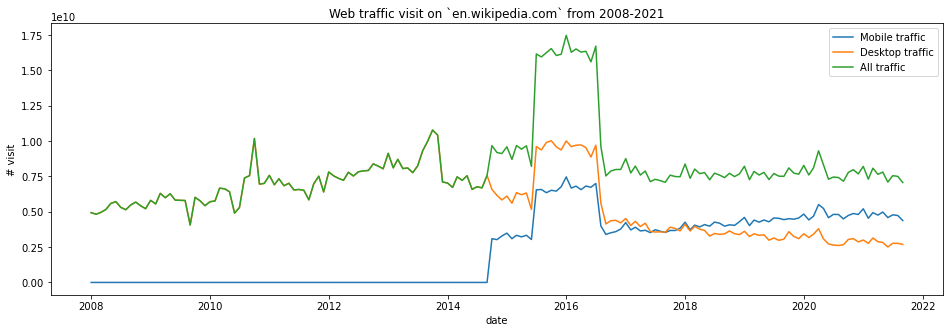

In [258]:
df['combined_date'] = pd.to_datetime(df['year'] + ' ' + df['month'])
df['combined_mobile'] = df['pagecount_mobile_views'] + df['pageview_mobile_views']
df['combined_desktop'] = df['pagecount_desktop_views'] + df['pageview_desktop_views']
df['combined_all'] = df['combined_mobile'] + df['combined_desktop']

def draw_plot(df, x, series, legends):
    plt.figure(figsize=(16,5))
    plt.title("Web traffic visit on `en.wikipedia.com` from {start}-{end}".format(**{'start': start_param[0:4], 'end': end_param[0:4]}))
    plt.xlabel("date")
    plt.ylabel("# visit")
    for i, y in enumerate(series):
        plt.plot(x, y, label=legends[i])
    plt.legend()
    plt.show()

draw_plot(df, 
          x=df.combined_date, 
          series=[df.combined_mobile, df.combined_desktop, df.combined_all], 
          legends=['Mobile traffic', 'Desktop traffic', 'All traffic'])